In [1]:
import pandas as pd
import glob
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

files = glob.glob("data/follows/farcasterdata-*.csv")
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [2]:
grouped = (
    df
    .groupby(['fid', 'target_fid'], as_index=False)['type']
    .sum()
    .rename(columns={'type': 'type_sum'})
)

filtered = grouped[grouped["type_sum"] >= 1]

In [3]:
in_deg = (
    filtered
    .groupby('target_fid')
    .size()                    # counts rows = in-degree
    .rename('in_degree')
)
grouped_with_in = grouped.merge(in_deg, left_on='target_fid', right_index=True)

small_in = grouped_with_in[grouped_with_in['in_degree'] > 1000]

In [4]:
G = nx.from_pandas_edgelist(
    small_in,
    source="fid",
    target="target_fid",
    create_using=nx.DiGraph()
)

pr = nx.pagerank(G, alpha=0.85)

pr_df = (
    pd.DataFrame(pr.items(), columns=["fid", "pageRank"])
      .sort_values("pageRank", ascending=False)
      .reset_index(drop=True)
)

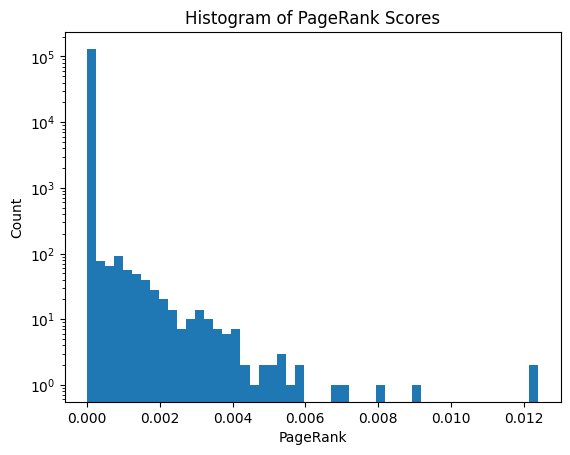

In [5]:
plt.figure()
plt.hist(pr_df['pageRank'], bins=50, log=True)
plt.xlabel('PageRank')
plt.ylabel('Count')
plt.title('Histogram of PageRank Scores')
plt.show()

In [6]:
sorted_pr = pr_df.sort_values(by="pageRank", ascending=False).reset_index(drop=True)

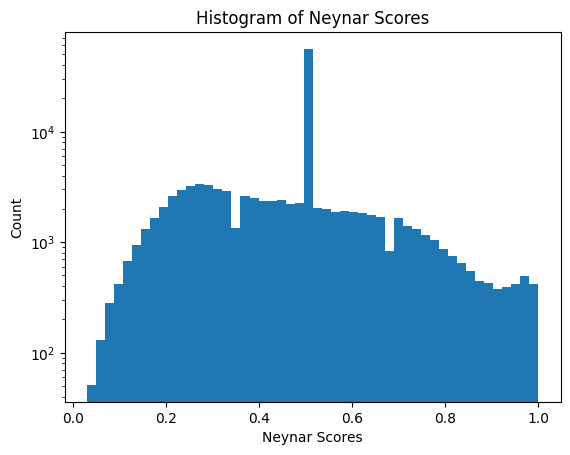

In [7]:
neynar_scores = pd.read_csv("./data/neynar_scores.csv")
neynar_pr = sorted_pr.merge(neynar_scores, on='fid')

plt.figure()
plt.hist(neynar_pr['score'], bins=50, log=True)
plt.xlabel('Neynar Scores')
plt.ylabel('Count')
plt.title('Histogram of Neynar Scores')
plt.show()

In [8]:
# sorted_pr.to_csv("data/pagerank.csv", index=False)

In [9]:
def bootstrap_correlation(x, y, n_bootstrap=1000, ci=95):
    n = len(x)
    bootstrap_corrs = []
    
    for _ in range(n_bootstrap):
        indices = np.random.choice(n, size=n, replace=True)
        boot_corr, _ = spearmanr(x[indices], y[indices])
        bootstrap_corrs.append(boot_corr)
    
    lower_bound = np.percentile(bootstrap_corrs, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrap_corrs, 100 - (100 - ci) / 2)
    
    return {
        "bootstrap_corrs": bootstrap_corrs,
        "corr_mean": np.mean(bootstrap_corrs),
        "ci_lower": lower_bound,
        "ci_upper": upper_bound
    }

In [10]:
epsilon = 1e-8
pr_log = np.log(neynar_pr['pageRank'] + epsilon)

results = bootstrap_correlation(pr_log, neynar_pr['score'])

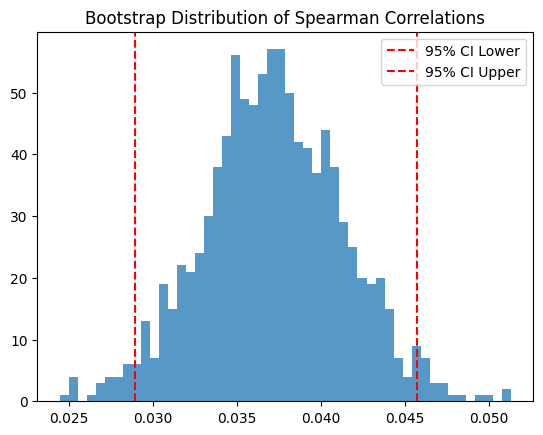

In [11]:
# Visualize bootstrap distribution:
plt.hist(results['bootstrap_corrs'], bins=50, alpha=0.75)
plt.axvline(results['ci_lower'], color='red', linestyle='--', label='95% CI Lower')
plt.axvline(results['ci_upper'], color='red', linestyle='--', label='95% CI Upper')
plt.title('Bootstrap Distribution of Spearman Correlations')
plt.legend()
plt.show()


In [12]:
neynar_pr[neynar_pr['fid'] == 270504]

,fid,pageRank,score
84264,270504,0.000001,0.99
